**前言**：本节内容是 [Datawhale六月组队学习 - 图神经网络- Task5 超大图上的节点表征学习](https://github.com/datawhalechina/team-learning-nlp/tree/master/GNN/Markdown%E7%89%88%E6%9C%AC) 的学习笔记，学习周期4天

### 基础准备

In [18]:
import torch_geometric
from torch_geometric.datasets import Reddit, Planetoid, PPI
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.data import ClusterData, ClusterLoader, NeighborSampler, Batch, DataLoader
from torch_geometric.nn import SAGEConv, BatchNorm

import torch
import torch.nn.functional as F
from torch.nn import ModuleList

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score

In [2]:
# 太大了，内存和CUDA不够用，弃用
dataset = Reddit('./dataset/Reddit') # 1.3G
data = dataset[0]
print(f'Number of features:\t{dataset.num_features}')
print(f'Number of classes:\t{dataset.num_classes}')
print(f'Number of nodes:\t{data.num_nodes}')
print(f'Number of edges:\t{data.num_edges}')

Number of features:	602
Number of classes:	41
Number of nodes:	232965
Number of edges:	114615892


In [3]:
path = './dataset/PPI'

dataset = PPI(path)
data = dataset[0]
print(f'Number of features:\t{dataset.num_features}')
print(f'Number of classes:\t{dataset.num_classes}')
print(f'Number of nodes:\t{data.num_nodes}')
print(f'Number of edges:\t{data.num_edges}')

Number of features:	50
Number of classes:	121
Number of nodes:	1767
Number of edges:	32318


### Cluster-GCN

图节点聚类与数据加载器生成

In [4]:
train_dataset = PPI(path, split='train')
val_dataset = PPI(path, split='val')
test_dataset = PPI(path, split='test')

In [5]:
train_data = Batch.from_data_list(train_dataset)
cluster_data = ClusterData(train_data,
                           num_parts=50,
                           recursive=False,
                           save_dir=train_dataset.processed_dir)
train_loader = ClusterLoader(cluster_data,
                             batch_size=1,
                             shuffle=True,
                             num_workers=12)

In [6]:
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

图神经网络的构建

In [7]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super(Net, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.batch_norms = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        self.batch_norms.append(BatchNorm(hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
            self.batch_norms.append(BatchNorm(hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

    def forward(self, x, edge_index):
        for conv, batch_norm in zip(self.convs[:-1], self.batch_norms):
            x = conv(x, edge_index)
            x = batch_norm(x)
            x = F.relu(x)
            x = F.dropout(x, p=0.2, training=self.training)
        return self.convs[-1](x, edge_index)

训练、验证与测试

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(in_channels=train_dataset.num_features,
            hidden_channels=1024,
            out_channels=train_dataset.num_classes,
            num_layers=6).to(device)
loss_op = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [14]:
def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        loss = loss_op(model(data.x, data.edge_index), data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_nodes
    return total_loss / train_data.num_nodes


@torch.no_grad()
def test(loader):
    model.eval()

    ys, preds = [], []
    for data in loader:
        ys.append(data.y)
        out = model(data.x.to(device), data.edge_index.to(device))
        preds.append((out > 0).float().cpu())

    y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
    return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0

In [15]:
loss_list = []; val_list = []; test_list = []
for epoch in range(1, 51):
    loss = train()
    loss_list.append(loss)
    if epoch % 5 == 0:
        val_f1 = test(val_loader); test_f1 = test(test_loader)
        val_list.append(val_f1); test_list.append(test_f1)
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Val: {val_f1:.4f}, Test: {test_f1:.4f}')
    else:
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

Epoch: 01, Loss: 0.6454
Epoch: 02, Loss: 0.5501
Epoch: 03, Loss: 0.5237
Epoch: 04, Loss: 0.5073
Epoch: 05, Loss: 0.4952, Val: 0.5432, Test: 0.5507
Epoch: 06, Loss: 0.4783
Epoch: 07, Loss: 0.4637
Epoch: 08, Loss: 0.4477
Epoch: 09, Loss: 0.4351
Epoch: 10, Loss: 0.4187, Val: 0.6501, Test: 0.6635
Epoch: 11, Loss: 0.4046
Epoch: 12, Loss: 0.3886
Epoch: 13, Loss: 0.3759
Epoch: 14, Loss: 0.3588
Epoch: 15, Loss: 0.3432, Val: 0.7222, Test: 0.7414
Epoch: 16, Loss: 0.3264
Epoch: 17, Loss: 0.3106
Epoch: 18, Loss: 0.2918
Epoch: 19, Loss: 0.2765
Epoch: 20, Loss: 0.2595, Val: 0.7811, Test: 0.8052
Epoch: 21, Loss: 0.2425
Epoch: 22, Loss: 0.2270
Epoch: 23, Loss: 0.2163
Epoch: 24, Loss: 0.2044
Epoch: 25, Loss: 0.1855, Val: 0.8634, Test: 0.8892
Epoch: 26, Loss: 0.1729
Epoch: 27, Loss: 0.1624
Epoch: 28, Loss: 0.1528
Epoch: 29, Loss: 0.1422
Epoch: 30, Loss: 0.1351, Val: 0.9018, Test: 0.9262
Epoch: 31, Loss: 0.1278
Epoch: 32, Loss: 0.1183
Epoch: 33, Loss: 0.1136
Epoch: 34, Loss: 0.1061
Epoch: 35, Loss: 0.098

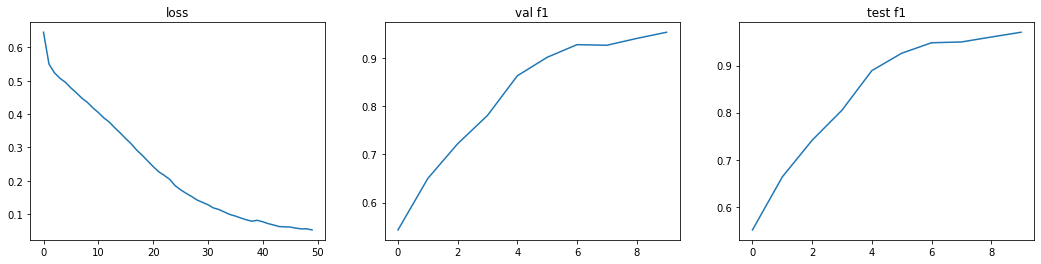

In [19]:
plt.figure(figsize=(18,4))
plt.subplot(1,3,1);plt.plot(loss_list);plt.title('loss')
plt.subplot(1,3,2);plt.plot(val_list);plt.title('val f1')
plt.subplot(1,3,3);plt.plot(test_list);plt.title('test f1')                    
plt.show()

### 作业
- 尝试将数据集切分成不同数量的簇进行实验，然后观察结果并进行比较。

121个簇

In [20]:
train_data = Batch.from_data_list(train_dataset)
# 由于classes为121，这里分为121个簇
cluster_data = ClusterData(train_data,
                           num_parts=121,
                           recursive=False,
                           save_dir=train_dataset.processed_dir)
train_loader = ClusterLoader(cluster_data,
                             batch_size=1,
                             shuffle=True,
                             num_workers=12)

Computing METIS partitioning...
Done!


In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(in_channels=train_dataset.num_features,
            hidden_channels=1024,
            out_channels=train_dataset.num_classes,
            num_layers=6).to(device)
loss_op = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [22]:
def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        loss = loss_op(model(data.x, data.edge_index), data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_nodes
    return total_loss / train_data.num_nodes


@torch.no_grad()
def test(loader):
    model.eval()

    ys, preds = [], []
    for data in loader:
        ys.append(data.y)
        out = model(data.x.to(device), data.edge_index.to(device))
        preds.append((out > 0).float().cpu())

    y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
    return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0

In [23]:
loss_list = []; val_list = []; test_list = []
for epoch in range(1, 51):
    loss = train()
    loss_list.append(loss)
    if epoch % 5 == 0:
        val_f1 = test(val_loader); test_f1 = test(test_loader)
        val_list.append(val_f1); test_list.append(test_f1)
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Val: {val_f1:.4f}, Test: {test_f1:.4f}')
    else:
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

Epoch: 01, Loss: 0.6156
Epoch: 02, Loss: 0.5412
Epoch: 03, Loss: 0.5229
Epoch: 04, Loss: 0.5051
Epoch: 05, Loss: 0.4897, Val: 0.5715, Test: 0.5775
Epoch: 06, Loss: 0.4763
Epoch: 07, Loss: 0.4575
Epoch: 08, Loss: 0.4478
Epoch: 09, Loss: 0.4299
Epoch: 10, Loss: 0.4153, Val: 0.6270, Test: 0.6389
Epoch: 11, Loss: 0.3975
Epoch: 12, Loss: 0.3813
Epoch: 13, Loss: 0.3699
Epoch: 14, Loss: 0.3509
Epoch: 15, Loss: 0.3328, Val: 0.7002, Test: 0.7200
Epoch: 16, Loss: 0.3200
Epoch: 17, Loss: 0.3025
Epoch: 18, Loss: 0.2889
Epoch: 19, Loss: 0.2759
Epoch: 20, Loss: 0.2612, Val: 0.7534, Test: 0.7799
Epoch: 21, Loss: 0.2463
Epoch: 22, Loss: 0.2337
Epoch: 23, Loss: 0.2247
Epoch: 24, Loss: 0.2143
Epoch: 25, Loss: 0.2053, Val: 0.7910, Test: 0.8179
Epoch: 26, Loss: 0.1989
Epoch: 27, Loss: 0.1876
Epoch: 28, Loss: 0.1811
Epoch: 29, Loss: 0.1721
Epoch: 30, Loss: 0.1652, Val: 0.8204, Test: 0.8488
Epoch: 31, Loss: 0.1630
Epoch: 32, Loss: 0.1557
Epoch: 33, Loss: 0.1507
Epoch: 34, Loss: 0.1467
Epoch: 35, Loss: 0.141

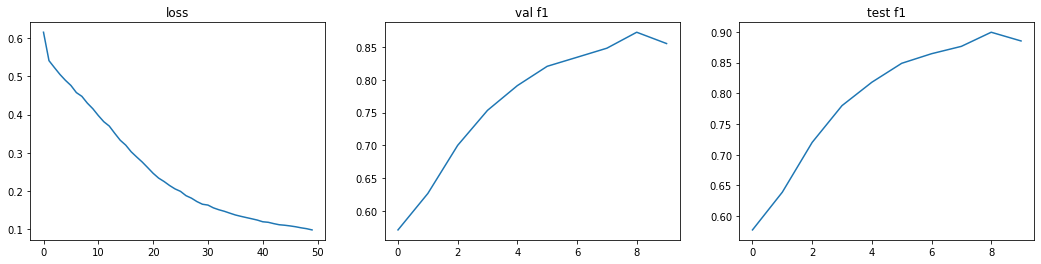

In [24]:
plt.figure(figsize=(18,4))
plt.subplot(1,3,1);plt.plot(loss_list);plt.title('loss')
plt.subplot(1,3,2);plt.plot(val_list);plt.title('val f1')
plt.subplot(1,3,3);plt.plot(test_list);plt.title('test f1')                    
plt.show()

20个簇

In [25]:
train_data = Batch.from_data_list(train_dataset)
# 由于classes为121，这里分为121个簇
cluster_data = ClusterData(train_data,
                           num_parts=20,
                           recursive=False,
                           save_dir=train_dataset.processed_dir)
train_loader = ClusterLoader(cluster_data,
                             batch_size=1,
                             shuffle=True,
                             num_workers=12)

Computing METIS partitioning...
Done!


In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(in_channels=train_dataset.num_features,
            hidden_channels=1024,
            out_channels=train_dataset.num_classes,
            num_layers=6).to(device)
loss_op = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [27]:
def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        loss = loss_op(model(data.x, data.edge_index), data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_nodes
    return total_loss / train_data.num_nodes


@torch.no_grad()
def test(loader):
    model.eval()

    ys, preds = [], []
    for data in loader:
        ys.append(data.y)
        out = model(data.x.to(device), data.edge_index.to(device))
        preds.append((out > 0).float().cpu())

    y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
    return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0

In [28]:
loss_list = []; val_list = []; test_list = []
for epoch in range(1, 51):
    loss = train()
    loss_list.append(loss)
    if epoch % 5 == 0:
        val_f1 = test(val_loader); test_f1 = test(test_loader)
        val_list.append(val_f1); test_list.append(test_f1)
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Val: {val_f1:.4f}, Test: {test_f1:.4f}')
    else:
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

Epoch: 01, Loss: 0.7210
Epoch: 02, Loss: 0.5750
Epoch: 03, Loss: 0.5514
Epoch: 04, Loss: 0.5408
Epoch: 05, Loss: 0.5258, Val: 0.4729, Test: 0.4717
Epoch: 06, Loss: 0.5109
Epoch: 07, Loss: 0.4999
Epoch: 08, Loss: 0.4820
Epoch: 09, Loss: 0.4672
Epoch: 10, Loss: 0.4574, Val: 0.6195, Test: 0.6231
Epoch: 11, Loss: 0.4476
Epoch: 12, Loss: 0.4339
Epoch: 13, Loss: 0.4198
Epoch: 14, Loss: 0.4090
Epoch: 15, Loss: 0.4008, Val: 0.6139, Test: 0.6299
Epoch: 16, Loss: 0.3836
Epoch: 17, Loss: 0.3700
Epoch: 18, Loss: 0.3587
Epoch: 19, Loss: 0.3477
Epoch: 20, Loss: 0.3314, Val: 0.7530, Test: 0.7672
Epoch: 21, Loss: 0.3187
Epoch: 22, Loss: 0.3043
Epoch: 23, Loss: 0.2890
Epoch: 24, Loss: 0.2812
Epoch: 25, Loss: 0.2689, Val: 0.8008, Test: 0.8170
Epoch: 26, Loss: 0.2542
Epoch: 27, Loss: 0.2389
Epoch: 28, Loss: 0.2261
Epoch: 29, Loss: 0.2142
Epoch: 30, Loss: 0.1997, Val: 0.8631, Test: 0.8836
Epoch: 31, Loss: 0.1888
Epoch: 32, Loss: 0.1767
Epoch: 33, Loss: 0.1628
Epoch: 34, Loss: 0.1524
Epoch: 35, Loss: 0.142

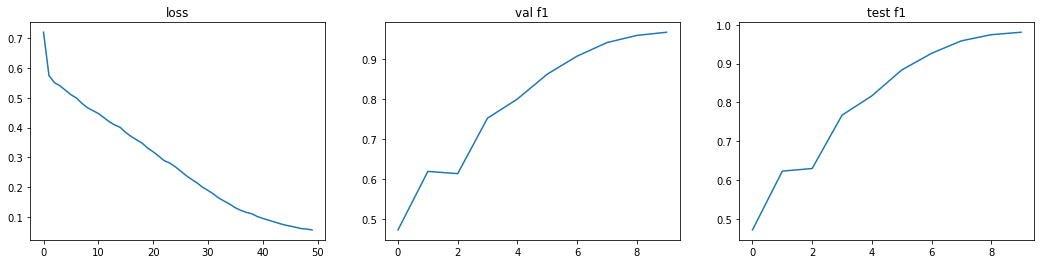

In [29]:
plt.figure(figsize=(18,4))
plt.subplot(1,3,1);plt.plot(loss_list);plt.title('loss')
plt.subplot(1,3,2);plt.plot(val_list);plt.title('val f1')
plt.subplot(1,3,3);plt.plot(test_list);plt.title('test f1')                    
plt.show()

**小结**：忘记监控资源消耗了。目前从分数上看，应该簇越少拟合的越快。主要是数据比较小，可能使用Reddit会更明显。